<a href="https://colab.research.google.com/github/itimes-digital/deep-learning-estudo/blob/main/serie_temporal_poluicao_china.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns

In [2]:
base = pd.read_csv('https://raw.githubusercontent.com/itimes-digital/deep-learning-estudo/main/dataset/poluicao.csv')
base.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
base.dropna(inplace=True)

In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.5+ MB


In [5]:
base.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [6]:
base.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [7]:
base_nova = base[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']]
base_nova.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0


In [8]:
base_nova.describe();

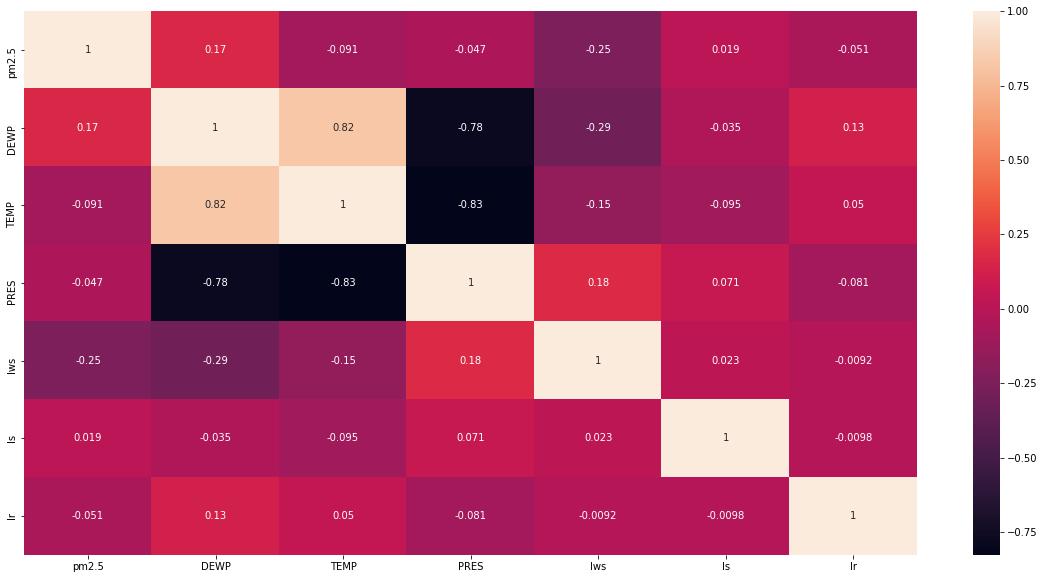

In [9]:
resultado_corr = base_nova.corr();
f, ax = plt.subplots(figsize = (20, 10));
sns.heatmap(resultado_corr, annot = True);

In [10]:
base_treinamento = base_nova.iloc[:, 1:7].values;
base_treinamento;

In [11]:
scaler = MinMaxScaler(feature_range = (0,1));
base_treinamento_normalizado = scaler.fit_transform(base_treinamento);

In [12]:
base_treinamento_normalizado.shape

(41757, 6)

In [13]:
previsores = [];
indice_poluicao_real = [];

for i in range(720, 41757):
  previsores.append(base_treinamento_normalizado[i - 720: i, 0:6]);
  indice_poluicao_real.append(base_treinamento_normalizado[i, 0]);

In [14]:
previsores, indice_poluicao_real = np.array(previsores), np.array(indice_poluicao_real);
previsores.shape

(41037, 720, 6)

In [15]:
model = Sequential();

model.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)));
model.add(Dropout(0.3));

model.add(LSTM(units = 50, return_sequences = True));
model.add(Dropout(0.3));

model.add(LSTM(units = 50, return_sequences = True));
model.add(Dropout(0.3));

model.add(LSTM(units = 50));
model.add(Dropout(0.3));

model.add(Dense(units = 1, activation = 'sigmoid'));

model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['mean_absolute_error']);

model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          42800     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 50)           30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 720, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 720, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 720, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [16]:
#Funções para ajudar a melhorar a acurácia/previsão do modelo

early = EarlyStopping(monitor = 'loss',
                      min_delta = 1e-10,
                      patience = 10,
                      verbose = 1);

reduce_ = ReduceLROnPlateau(monitor = 'loss',
                            factor = 0.2,
                            patience = 5,
                            verbose = 1);

checkpoint = ModelCheckpoint(filepath = 'pesos.h5',
                             monitor = 'loss',
                             save_best_only = True,
                             verbose = 1);

In [ ]:
history_ = model.fit(previsores, 
                     indice_poluicao_real,
                     epochs = 10,
                     batch_size = 32,
                     callbacks = [early, reduce_, checkpoint]);

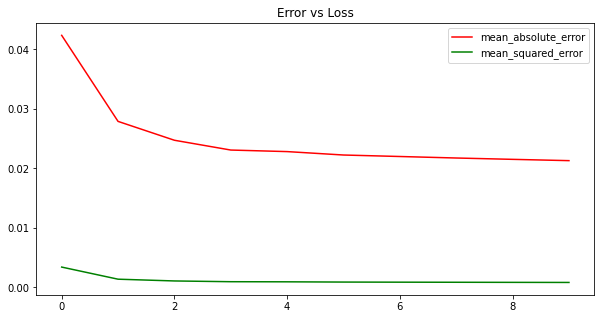

In [21]:
plt.figure(figsize = (10, 5));
plt.plot(history_.history['mean_absolute_error'], color = 'red', label = 'mean_absolute_error');
plt.plot(history_.history['loss'], color = 'green', label = 'mean_squared_error');
plt.title('Error vs Loss');
plt.legend();
plt.show();

In [26]:
np.mean(history_.history['loss'])

0.0011941770208068192

In [27]:
np.mean(history_.history['mean_absolute_error']) 

0.024965006858110428

In [23]:
model_json = model.to_json()
model_json

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 720, 6], "dtype": "float32", "sparse": false, "ragged": false, "name": "lstm_input"}}, {"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "batch_input_shape": [null, 720, 6], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 100, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": n

In [24]:
with open('model_json.json', 'w') as json_file:
  json_file.write(model_json)

In [25]:
# Procedimento para savar os pesos da rede neural no formato h5
model.save_weights('model_json.h5')